In [1]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gb_preds = pd.read_csv('tmp' + os.sep + 'validation_set_preditions_gb_prev.csv')
rf_preds = pd.read_csv('tmp' + os.sep + 'validation_set_preditions_rf.csv')
xtrees_preds = pd.read_csv('tmp' + os.sep + 'validation_set_preditions_xtrees.csv')
xgb_preds = pd.read_csv('tmp' + os.sep + 'validation_set_preditions_xgb.csv')

In [3]:
merged = pd.DataFrame()
merged['gb_preds'] = gb_preds
merged['rf_preds'] = rf_preds
merged['xtrees_preds'] = xtrees_preds
merged['xgb_preds'] = xgb_preds

In [4]:
merged.head()

,gb_preds,rf_preds,xtrees_preds,xgb_preds
0,0.0476,0.5573,0.5369,0.0366
1,0.0323,0.4832,0.4985,0.0409
2,0.1050,0.6289,0.6485,0.1178
3,0.0282,0.4539,0.4949,0.0260
4,0.0225,0.3618,0.3285,0.0229


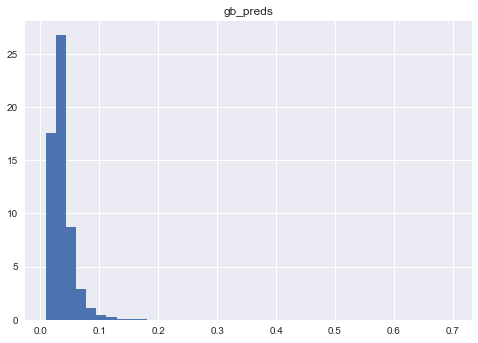

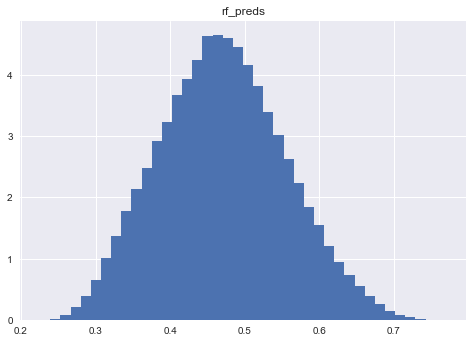

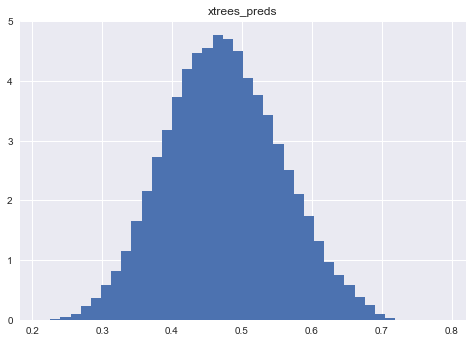

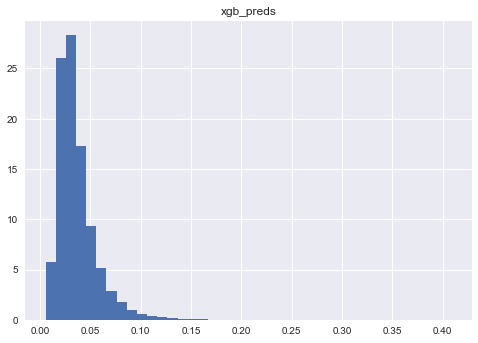

In [5]:
for p in ['gb_preds', 'rf_preds', 'xtrees_preds', 'xgb_preds']:
    plt.hist(merged[p], normed=True, bins=40)
    plt.title(p)
    plt.show()

## Correlations

In [14]:
for p in ['gb_preds', 'rf_preds', 'xtrees_preds', 'xgb_preds']:
    merged[p+'_ranked'] = merged[p].rank(pct=True, method='dense')

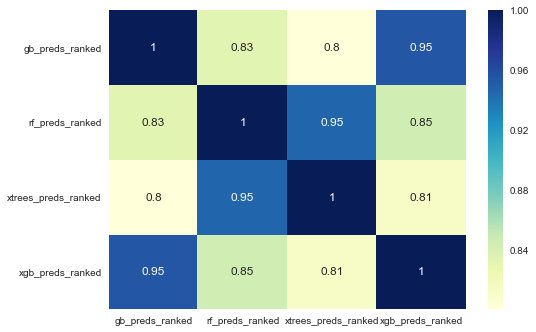

In [15]:
sns.heatmap(merged[['gb_preds_ranked', 'rf_preds_ranked', 'xtrees_preds_ranked', 'xgb_preds_ranked']].corr(), annot=True, cmap="YlGnBu")
plt.show()

In [16]:
merged.head()

,gb_preds,rf_preds,xtrees_preds,xgb_preds,gb_preds_ranked,rf_preds_ranked,xtrees_preds_ranked,xgb_preds_ranked
0,0.0476,0.5573,0.5369,0.0366,0.001930,0.015548,0.014841,0.001532
1,0.0323,0.4832,0.4985,0.0409,0.001151,0.011776,0.012886,0.001751
2,0.1050,0.6289,0.6485,0.1178,0.004852,0.019194,0.020522,0.005666
3,0.0282,0.4539,0.4949,0.0260,0.000942,0.010284,0.012702,0.000993
4,0.0225,0.3618,0.3285,0.0229,0.000652,0.005595,0.004231,0.000835


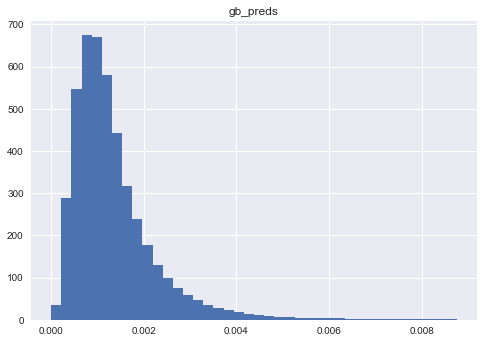

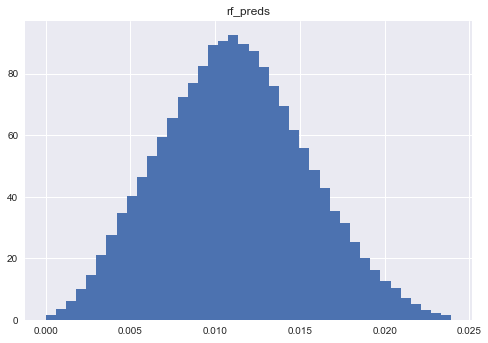

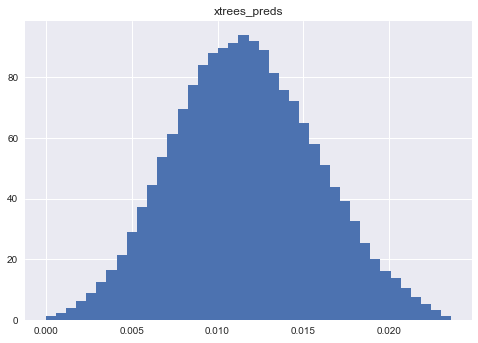

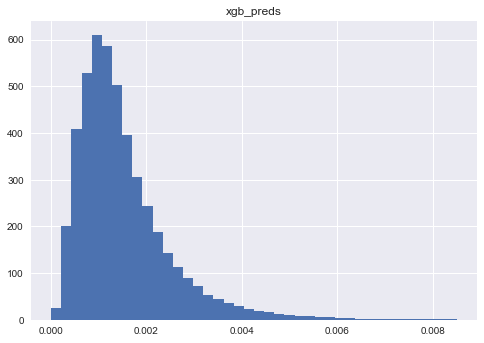

In [22]:
for p in ['gb_preds', 'rf_preds', 'xtrees_preds', 'xgb_preds']:
    plt.hist(merged[p+'_ranked'], normed=True, bins=40)
    plt.title(p)
    plt.show()

In [9]:
from sklearn.metrics import roc_curve, auc

def gini(y, pred):
    fpr, tpr, thr = roc_curve(y, pred, pos_label=1)
    g = 2 * auc(fpr, tpr) -1
    return g

def gini_norm(y, pred):
    normed = gini(y, pred) / gini(y,y)
    return normed

In [10]:
y_test = pd.read_csv('tmp' + os.sep + 'test_set_targets.csv')

In [11]:
for p in ['gb_preds', 'rf_preds', 'xtrees_preds', 'xgb_preds']:
    print('{}: {:.4f}'.format(p, gini_norm(y_test, merged[p])))

gb_preds: 0.2786
rf_preds: 0.2663
xtrees_preds: 0.2561
xgb_preds: 0.2838


In [12]:
averaged = merged[['gb_preds_ranked', 'rf_preds_ranked', 'xtrees_preds_ranked', 'xgb_preds_ranked']].mean(axis=1)
gini_norm(y_test, averaged)

0.27103458837133521

In [13]:
averaged = merged[['rf_preds_ranked', 'gb_preds', 'xgb_preds']].mean(axis=1)
gini_norm(y_test, averaged)

0.2833219203292765

In [17]:
import numpy as np

y_pred_xgb = merged['xgb_preds_ranked']
y_pred_rf = merged['gb_preds_ranked']
y_pred_gb = merged['gb_preds_ranked']

best_single_classifer_score = 0.2838

weights_xgb = np.arange(0.6, 1, 0.025)
max_improvement_over_best = 0
w_xgb_argmax = 0
w_rf_argmax = 0
w_gb_argmax = 0
for weight_xgb in weights_xgb:
    parts = np.arange(0.1, 1, 0.025)
    for weight_rf in [(1 - weight_xgb) * part for part in parts ]:
        parts2 = np.arange(0.1, 1, 0.025)
        weight_gb = 1 - (weight_xgb + weight_rf)
        averaged_preds = weight_xgb * y_pred_xgb + weight_rf * y_pred_rf + weight_gb * y_pred_gb
        g = gini_norm(y_test, averaged_preds)
        better_by = g - best_single_classifer_score
        if (better_by > max_improvement_over_best):
            max_improvement_over_best = better_by
            w_xgb_argmax = weight_xgb
            w_rf_argmax = weight_rf
            w_gb_argmax = weight_gb
            print('Best improvement: ' + str(max_improvement_over_best), w_xgb_argmax, w_rf_argmax, w_gb_argmax)

Best improvement: 8.83096073717e-06 0.65 0.035 0.315
Best improvement: 8.97405471029e-06 0.65 0.07875 0.27125
Best improvement: 9.45543751146e-06 0.65 0.1225 0.2275
Best improvement: 6.47080564405e-05 0.675 0.0325 0.2925
Best improvement: 6.47645602144e-05 0.675 0.040625 0.284375
Best improvement: 6.52349357866e-05 0.675 0.04875 0.27625
Best improvement: 6.52518135374e-05 0.675 0.073125 0.251875
Best improvement: 6.53670225311e-05 0.675 0.284375 0.040625
Best improvement: 0.000110455566491 0.7 0.03 0.27
Best improvement: 0.000112540335604 0.7 0.0375 0.2625
Best improvement: 0.00015712181323 0.725 0.0275 0.2475
Best improvement: 0.00015730233178 0.725 0.034375 0.240625
Best improvement: 0.000157324346237 0.725 0.048125 0.226875
Best improvement: 0.000157347828325 0.725 0.09625 0.17875
Best improvement: 0.000157352965032 0.725 0.103125 0.171875
Best improvement: 0.000157532015952 0.725 0.15125 0.12375
Best improvement: 0.000181826437293 0.75 0.025 0.225
Best improvement: 0.00018439479065

In [24]:
import numpy as np

y_pred_xgb = merged['xgb_preds_ranked']
y_pred_rf = merged['rf_preds_ranked']
y_pred_gb = merged['gb_preds_ranked']

best_single_classifer_score = 0.2838

weights_xgb = np.arange(0.8, 1, 0.02)
max_improvement_over_best = 0
w_xgb_argmax = 0
w_rf_argmax = 0
w_gb_argmax = 0
for weight_xgb in weights_xgb:
    parts = np.arange(0.1, 1, 0.02)
    for weight_rf in [(1 - weight_xgb) * part for part in parts ]:
        parts2 = np.arange(0.1, 1, 0.025)
        weight_gb = 1 - (weight_xgb + weight_rf)
        averaged_preds = weight_xgb * y_pred_xgb + weight_rf * y_pred_rf + weight_gb * y_pred_gb
        g = gini_norm(y_test, averaged_preds)
        better_by = g - best_single_classifer_score
        if (better_by > max_improvement_over_best):
            max_improvement_over_best = better_by
            w_xgb_argmax = weight_xgb
            w_rf_argmax = weight_rf
            w_gb_argmax = weight_gb
            print('Best improvement: ' + str(max_improvement_over_best), w_xgb_argmax, w_rf_argmax, w_gb_argmax)

Best improvement: 0.0004665012561 0.8 0.02 0.18
Best improvement: 0.0004756079033 0.82 0.018 0.162
Best improvement: 0.00048437185878 0.82 0.0216 0.1584
Best improvement: 0.000490891073423 0.84 0.0192 0.1408
Best improvement: 0.000499520006898 0.84 0.0224 0.1376
Best improvement: 0.000508824050399 0.86 0.0224 0.1176
Best improvement: 0.00050922985023 0.88 0.024 0.096


In [25]:
import numpy as np

y_pred_xgb = merged['xgb_preds_ranked']
y_pred_rf = merged['rf_preds_ranked']
y_pred_gb = merged['gb_preds_ranked']
y_pred_xtrees = merged['xtrees_preds_ranked']

best_single_classifer_score = 0.2838
weights_xgb = np.arange(0.85, 1, 0.02)
max_improvement_over_best = 0
w_xgb_argmax = 0
w_gb_argmax = 0
w_rf_argmax = 0
w_xtrees_argmax = 0
for weight_xgb in weights_xgb:
    parts = np.arange(0.1, 1, 0.025)
    for weight_rf in [(1 - weight_xgb) * part for part in parts ]:
        parts2 = np.arange(0.1, 1, 0.025)
        for weight_gb in [(1 - (weight_xgb + weight_rf)) * part for part in parts2 ]:
            weight_xtrees = 1 - (weight_xgb + weight_rf + weight_gb)
            averaged_preds = weight_xgb * y_pred_xgb + weight_rf * y_pred_rf + weight_gb * y_pred_gb + weight_xtrees * y_pred_xtrees
            g = gini_norm(y_test, averaged_preds)
            better_by = g - best_single_classifer_score
            if (better_by > max_improvement_over_best):
                max_improvement_over_best = better_by
                w_xgb_argmax = weight_xgb
                w_gb_argmax = weight_gb
                w_rf_argmax = weight_rf
                w_xtrees_argmax = weight_xtrees
                print('Best improvement: ' + str(max_improvement_over_best), w_xgb_argmax, w_gb_argmax, w_rf_argmax, w_xtrees_argmax)

Best improvement: 8.04601345057e-05 0.85 0.10125 0.015 0.03375
Best improvement: 0.00016091563805 0.85 0.104625 0.015 0.030375
Best improvement: 0.000240169152222 0.85 0.108 0.015 0.027
Best improvement: 0.000309423699855 0.85 0.111375 0.015 0.023625
Best improvement: 0.000366642209827 0.85 0.11475 0.015 0.02025
Best improvement: 0.000414927252998 0.85 0.118125 0.015 0.016875
Best improvement: 0.000456140518645 0.85 0.1215 0.015 0.0135
Best improvement: 0.000480716725041 0.85 0.124875 0.015 0.010125
Best improvement: 0.000491280729319 0.85 0.12825 0.015 0.00675
Best improvement: 0.00049568728987 0.85 0.1246875 0.01875 0.0065625
Best improvement: 0.000501005982771 0.85 0.12796875 0.01875 0.00328125
Best improvement: 0.000501513782921 0.85 0.1243125 0.0225 0.0031875
Best improvement: 0.00050200470532 0.87 0.104975 0.0195 0.005525
Best improvement: 0.000506997584252 0.87 0.1077375 0.0195 0.0027625
Best improvement: 0.000509204166696 0.87 0.10456875 0.02275 0.00268125
Best improvement: 0.0